In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import glob

from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

%matplotlib inline

## Analytics - Part2 (Customer Segmentation)
- RFM
- Elbow method & Silhouette score
- Kmeans
- Visualization of Clusters


*******************************************************************************************************************************************************************
### RFM Segmentation
- RFM segmentation refers to a common method used for customer segmentation based on the concepts of Recency, Frequency, and Monetary Value. RFM analysis is widely used in marketing and customer analytics to identify and group customers based on their purchasing behavior. Additionally, I will use extra features, which are the number of unique categories that each customer bought and the number of orders made by each customer. So, basically, RFM + $\alpha$ method will be applied for the customer segmentation in the following section.

### Load data

In [2]:
features = ['customer_unique_id', 'order_id', 'order_status', 'product_category_name', 'order_purchase_timestamp', 'payment_value']
df = pd.read_csv("./datasets/olist_master.csv")
df = df[features]
print(df.isna().sum())
print()
print(df.shape)

customer_unique_id          0
order_id                    0
order_status                0
product_category_name       0
order_purchase_timestamp    0
payment_value               0
dtype: int64

(116581, 6)


### Preprocessing & RFM + $\alpha$ Analysis

In [3]:
#preprocessing
df = df[df.order_status == 'delivered'].reset_index(drop=True)
df.order_purchase_timestamp = df.order_purchase_timestamp.str.slice(0,10)
df['created_at'] = df.order_purchase_timestamp.apply(lambda x: pd.to_datetime(x, format = "%Y-%m-%d"))
df.drop_duplicates(inplace=True)
df.head()

,customer_unique_id,order_id,order_status,product_category_name,order_purchase_timestamp,payment_value,created_at
0,5ee8fe956c2631afc0a1dcc1920d0e3d,00010242fe8c5a6d1ba2dd792cb16214,delivered,Cool Stuff,2017-09-13,72.19,2017-09-13
1,8b3f917f4307d3e5cf34c0b43d6e6f50,130898c0987d1801452a8ed92a670612,delivered,Cool Stuff,2017-06-28,73.86,2017-06-28
2,69ba88e17ea574da9c9b8c8834a583d1,532ed5e14e24ae1f0d735b91524b98b9,delivered,Cool Stuff,2018-05-18,83.23,2018-05-18
3,cbe063493a222cb17024ff0285b4ecb6,6f8c31653edb8c83e1a739408b5ff750,delivered,Cool Stuff,2017-08-01,75.07,2017-08-01
4,ffab5330bd7b40979ab6726b2e02292e,7d19f4ef4d04461989632411b7e588b9,delivered,Cool Stuff,2017-08-10,72.19,2017-08-10


In [31]:
#rfm + number of categories
class calculate_rfm():
    def __init__(self, df):
        self.df = df 
        self.df.created_at = pd.to_datetime(self.df.created_at)
        
    def calculate_rfm_modified(self):        
        data = df.sort_values(by=['customer_unique_id', 'created_at'])
        # frequency
        df_tmp = data[['customer_unique_id', 'created_at']].copy().drop_duplicates()
        df_tmp['rn'] = df_tmp.groupby('customer_unique_id')['created_at'].cumcount() + 1 
        df_tmp['rn_idx'] = df_tmp.rn - 1
        df_freq_tmp = pd.merge(df_tmp, df_tmp,
                               left_on=['customer_unique_id', 'rn'],
                               right_on=['customer_unique_id', 'rn_idx'],
                               how='left')
        df_freq_tmp['frequency'] = (df_freq_tmp.created_at_y - df_freq_tmp.created_at_x).dt.days
        df_rfm = df_freq_tmp.groupby('customer_unique_id', as_index=False).frequency.mean().fillna(0)
        
        # order_count, monetary, nproduct
        df_rfm = pd.merge(df_rfm,
                          data.groupby('customer_unique_id', as_index=False).agg(orders=('order_id', 'count'),
                                                                          monetary=('payment_value', 'sum'),
                                                                          n_categories=('product_category_name', 'nunique')),
                          on='customer_unique_id',
                          how='left')
        
        # recency
        df_rfm = pd.merge(df_rfm, 
                          data.groupby('customer_unique_id', as_index=False).agg(recency=('created_at', 'max')),
                          on = 'customer_unique_id',
                          how = 'left')
        df_rfm['recency'] = (data.created_at.max() - df_rfm.recency).dt.days
        
        df_rfm = df_rfm.set_index('customer_unique_id')
        
        return df_rfm
    
    def viz_rfm(self, rfm):
        plt.figure(figsize = (18, 16))
        
        plt.subplot(5,1,1)
        sns.distplot(rfm.recency)
        # plt.title("Distribution of Recency")

        plt.subplot(5,1,2)
        sns.distplot(rfm.frequency)
        # plt.title('Distribution of Frequency')

        plt.subplot(5,1,3)
        sns.distplot(rfm.monetary)
        # plt.title("Distribution of Monetary")

        plt.subplot(5,1,4)
        sns.distplot(rfm.n_categories)
        # plt.title('Distribution of number of categories bought')

        plt.subplot(5,1,5)
        sns.distplot(rfm.orders)

        plt.show()

In [32]:
rfm_class = calculate_rfm(df)
df_rfm = rfm_class.calculate_rfm_modified()

In [33]:
df_rfm.head()

,frequency,orders,monetary,n_categories,recency
customer_unique_id,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,111.0,2,136.26,2,169
0000f46a3911fa3c0805444483337064,134.0,3,583.87,3,125
0004bd2a26a76fe21f786e4fbd80607f,218.5,3,336.11,3,7
00050ab1314c0e55a6ca13cf7181fecf,0.0,1,80.18,1,219
0005ef4cd20d2893f0d9fbd94d3c0d97,0.0,1,187.91,1,481


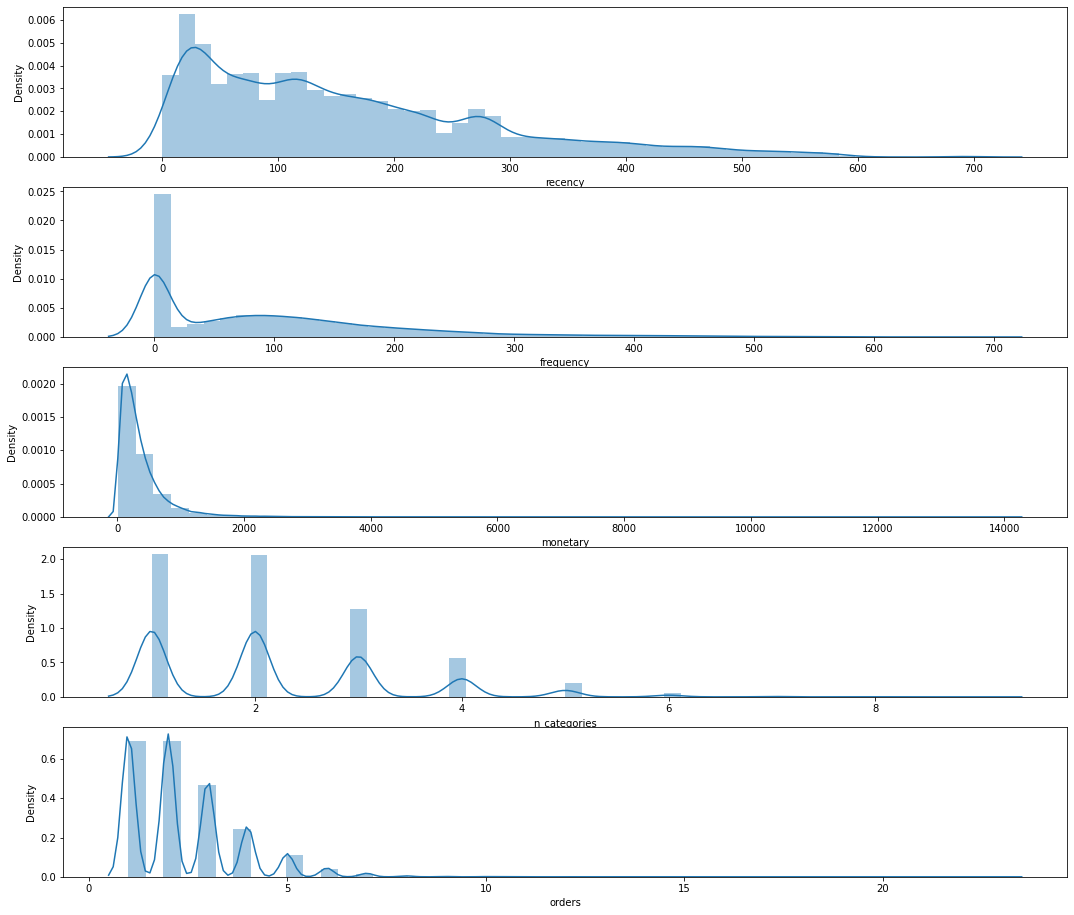

In [34]:
rfm_class.viz_rfm(df_rfm)

### Segmentation

In [103]:
class Segmentation():
    def __init__(self, df_rfm):
        self.df_rfm = df_rfm

    def scaler(self):
        scaler = StandardScaler()
        scaled_rfm = scaler.fit_transform(df_rfm)
        scaled_rfm = pd.DataFrame(scaled_rfm, index=df_rfm.index, columns=df_rfm.columns)
        return scaled_rfm
    
    def elbow_plot(self, scaled_df):
        kmeans_per_k = [KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=42).fit(scaled_df) for k in range(1,10)]
        inertias = [model.inertia_ for model in kmeans_per_k]        
        plt.figure(figsize=(12, 9))
        plt.plot(range(1,10), inertias, 'bo-')
        plt.xlabel('$k$', fontsize=14)
        plt.ylabel('$inertia$', fontsize=14)
        plt.show()

    def silhouette_score(self, scaled_df):
        kmeans_per_k = [KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=42).fit(scaled_df) for k in range(1,10)]
        silhouette_scores = [silhouette_score(scaled_df, model.labels_) for model in kmeans_per_k[1:]]
        plt.figure(figsize=(12,9))
        plt.plot(range(2,10), silhouette_scores, 'bo-')
        plt.xlabel("$k$", fontsize=14)
        plt.ylabel('silhouette score', fontsize=14)
        plt.show()

    def silhouette_diagram(self, scaled_df):
        kmeans_per_k = [KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=42).fit(scaled_df) for k in range(1,10)]
        silhouette_scores = [silhouette_score(scaled_df, model.labels_) for model in kmeans_per_k[1:]]

        plt.figure(figsize=(12, 9))

        for k in (2, 3, 5, 6):
            # 1 2 3 4
            if k in (2,3):
                plt.subplot(2, 2, k - 1)
            else:
                plt.subplot(2, 2, k-2)
            y_pred = kmeans_per_k[k - 1].labels_
            silhouette_coefficients = silhouette_samples(scaled_df, y_pred)

            padding = len(scaled_df) // 30
            pos = padding
            ticks = []
            for i in range(k):
                coeffs = silhouette_coefficients[y_pred == i]
                coeffs.sort()

                color = mpl.cm.Spectral(i / k)
                plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                                facecolor=color, edgecolor=color, alpha=0.7)
                ticks.append(pos + len(coeffs) // 2)
                pos += len(coeffs) + padding

            plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
            plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
            if k in (2, 5):
                plt.ylabel("Cluster")
            
            if k in (5, 6):
                plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
                plt.xlabel("Silhouette Coefficient")
            else:
                plt.tick_params(labelbottom=False)
            
            plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
            plt.title("$k={}$".format(k), fontsize=16)

        plt.show()
            

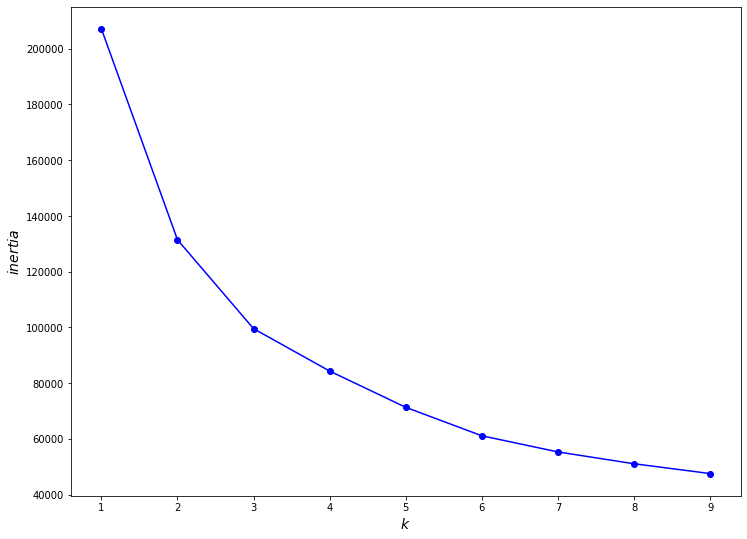

In [96]:
seg = Segmentation(df_rfm)
scaled_df = seg.scaler()
seg.elbow_plot(scaled_df)

- In the above elbow plot, it seems not obvious which $k$ would be the optimal one. So, I will also check the silhoutte scores and diagrams for each k.

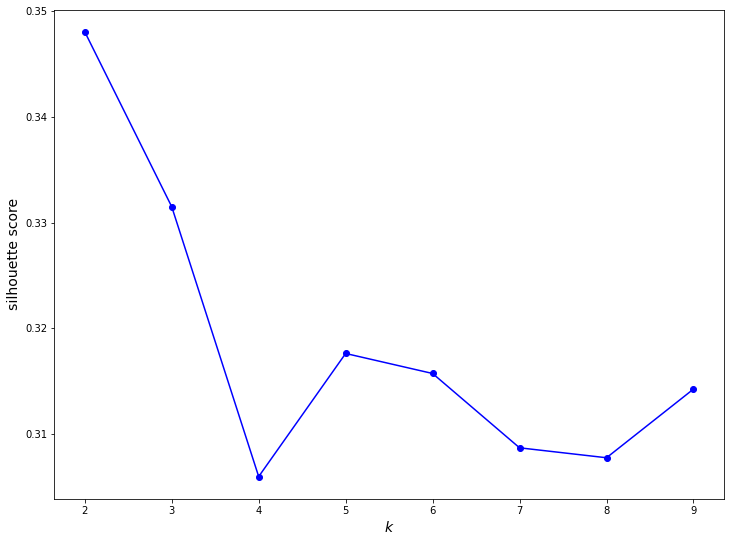

In [97]:
seg.silhouette_score(scaled_df)
seg.silhouette_diagram(scaled_df)

### Final Model